In [104]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [105]:
import numpy as np
from math import radians, sin, cos, atan2, sqrt
import pandas as pd


def preprocess_data(df, label_encoders=None, is_training=True):
    """
    Enhanced preprocessing with advanced feature engineering.
    """
    df_processed = df.copy()
    
    # Convert datetime columns
    df_processed['trans_date'] = pd.to_datetime(df_processed['trans_date'])
    df_processed['trans_time'] = pd.to_datetime(df_processed['trans_time'], format='%H:%M:%S')
    df_processed['dob'] = pd.to_datetime(df_processed['dob'], errors='coerce')
    
    # Temporal features
    df_processed['hour'] = df_processed['trans_time'].dt.hour
    df_processed['day'] = df_processed['trans_date'].dt.day
    df_processed['month'] = df_processed['trans_date'].dt.month
    df_processed['weekday'] = df_processed['trans_date'].dt.weekday
    df_processed['year'] = df_processed['trans_date'].dt.year
    df_processed['quarter'] = df_processed['trans_date'].dt.quarter
    
    # Time-based features
    df_processed['is_weekend'] = df_processed['weekday'].isin([5, 6]).astype(int)
    df_processed['is_night'] = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 5)).astype(int)
    df_processed['is_morning'] = ((df_processed['hour'] >= 6) & (df_processed['hour'] <= 11)).astype(int)
    df_processed['is_rush_hour'] = df_processed['hour'].isin([8, 9, 17, 18]).astype(int)
    df_processed['is_business_hour'] = ((df_processed['hour'] >= 9) & (df_processed['hour'] <= 17)).astype(int)
    
    # Distance features (Euclidean)
    df_processed['distance'] = np.sqrt(
        (df_processed['lat'] - df_processed['merch_lat'])**2 + 
        (df_processed['long'] - df_processed['merch_long'])**2
    )
    df_processed['distance_km'] = df_processed['distance'] * 111
    df_processed['distance_log'] = np.log1p(df_processed['distance'])
    
    # Distance features (Haversine)
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in kilometers
        d_lat = np.radians(lat2 - lat1)
        d_lon = np.radians(lon2 - lon1)
        a = np.sin(d_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    df_processed['haversine_distance'] = df_processed.apply(
        lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1
    )
    df_processed['haversine_distance_log'] = np.log1p(df_processed['haversine_distance'])
    
    # Age features
    df_processed['age'] = (df_processed['trans_date'] - df_processed['dob']).dt.days / 365.25
    df_processed['age_squared'] = df_processed['age'] ** 2
    df_processed['age_decade'] = (df_processed['age'] // 10) * 10
    
    # Amount transformations
    df_processed['amount_log'] = np.log1p(df_processed['amt'])
    df_processed['amount_sqrt'] = np.sqrt(df_processed['amt'])
    df_processed['amount_squared'] = df_processed['amt'] ** 2
    
    # Population features
    df_processed['city_pop_log'] = np.log1p(df_processed['city_pop'])
    df_processed['city_pop_sqrt'] = np.sqrt(df_processed['city_pop'])
    
    # Drop unnecessary columns
    columns_to_drop = ['trans_date', 'trans_time', 'cc_num', 'first', 'last', 
                       'street', 'city', 'dob', 'unix_time', 'zip', 'trans_num']
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
    
    # Categorical encoding
    cat_columns = ['category', 'gender', 'state', 'job', 'merchant']
    if is_training:
        label_encoders = {}
        for col in cat_columns:
            label_encoders[col] = LabelEncoder()
            df_processed[col] = label_encoders[col].fit_transform(df_processed[col].astype(str))
        return df_processed, label_encoders
    else:
        for col in cat_columns:
            if col in label_encoders:
                df_processed[col] = df_processed[col].astype(str)
                unseen = ~df_processed[col].isin(label_encoders[col].classes_)
                df_processed.loc[unseen, col] = label_encoders[col].classes_[0]
                df_processed[col] = label_encoders[col].transform(df_processed[col])
        return df_processed

In [106]:
# Load your data (assume train.csv and test.csv)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_processed, label_encoders = preprocess_data(train_data, is_training=True)
X_train = train_processed.drop('is_fraud', axis=1)
y_train = train_processed['is_fraud']

# Preprocess testing data
test_processed = preprocess_data(test_data, label_encoders=label_encoders, is_training=False)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


Validation F1 Score: 0.977195187645897

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65681
           1       0.99      0.96      0.98      8460

    accuracy                           0.99     74141
   macro avg       0.99      0.98      0.99     74141
weighted avg       0.99      0.99      0.99     74141



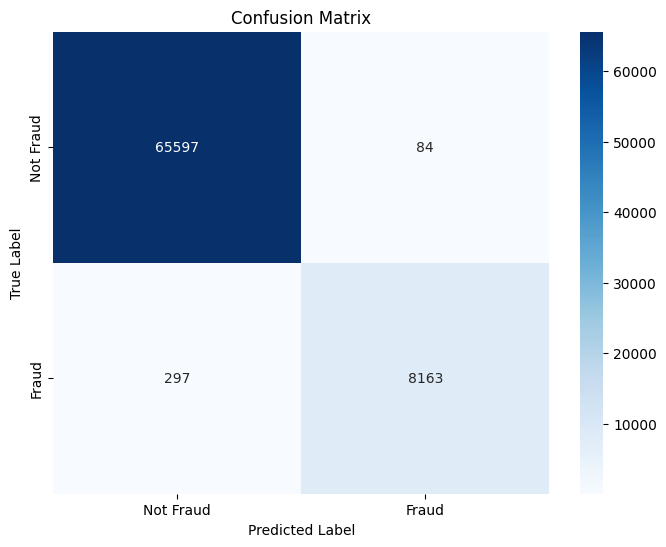

In [107]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    booster='gbtree',
    n_estimators=200,      # Number of trees
    learning_rate=0.2,    # Step size shrinkage used to prevent overfitting
    max_depth=9,           # Maximum tree depth for base learners
    min_child_weight=1,    # Minimum sum of instance weight(hessian) needed in a child
    subsample=0.8,         # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,               # Minimum loss reduction required to make a further partition
    random_state=42        # For reproducibility
)
# Train the model
xgb_model.fit(X_train_split, y_train_split)

# Predictions on validation set
y_val_pred = xgb_model.predict(X_val_split)

# F1 Score
f1 = f1_score(y_val_split, y_val_pred)
print(f"Validation F1 Score: {f1}")

# Classification Report
report = classification_report(y_val_split, y_val_pred)
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_split, y_val_pred)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [108]:

test_predictions = xgb_model.predict(test_processed)

submission = pd.DataFrame({
    'id': test_data['id'],
    'is_fraud': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' generated successfully.")

Submission file 'submission.csv' generated successfully.


In [109]:
# Load the two submission files
submission1 = pd.read_csv('submission.csv')
submission2 = pd.read_csv('submission-2.csv')

# Check if both submissions have the same structure
if submission1.shape != submission2.shape or not all(submission1.columns == submission2.columns):
    raise ValueError("The two submissions have different shapes or column names.")

# Compare the 'is_fraud' column
matches = (submission1['is_fraud'] == submission2['is_fraud'])

# Calculate similarity metrics
total_predictions = len(matches)
matching_predictions = matches.sum()
similarity_percentage = (matching_predictions / total_predictions) * 100

print(f"Total Predictions: {total_predictions}")
print(f"Matching Predictions: {matching_predictions}")
print(f"Similarity Percentage: {similarity_percentage:.2f}%")

# Optional: Display mismatches for inspection
mismatches = submission1[~matches]
print("Mismatched Predictions:")
print(mismatches.head())

Total Predictions: 92676
Matching Predictions: 92416
Similarity Percentage: 99.72%
Mismatched Predictions:
          id  is_fraud
214   603130         0
285   548123         0
488   248344         0
761   328088         0
1224  570292         1
